### Importing necessary libraries

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import requests 
from bs4 import BeautifulSoup 
import string  
import pickle
from nltk.corpus import stopwords 
import re 
from nltk.tokenize import RegexpTokenizer
import nltk 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score,confusion_matrix,precision_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

### Web Scraping

In [4]:
url = 'https://www.airlinequality.com/airline-reviews/qantas-airways/'
response = requests.get(url)
html_content = response.text

In [5]:
response

<Response [200]>

In [7]:
def parse_star_rating(star_container):
    # Check for star ratings
    stars = star_container.find_all('span', class_='star')
    if stars:
        rating = sum(1 for star in stars if 'fill' in star['class'])
        return rating
    # Handle textual responses
    textual_rating = star_container.text.strip().lower()
    if textual_rating in ['yes', 'no']:
        return textual_rating
    return 'No rating'  # Default case if no stars or known text is found

def fetch_reviews(url):
    # Fetch the page
    response = requests.get(url)
    response.raise_for_status()  # This will raise an error if the fetch fails

    # Parse the HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all review articles
    reviews = soup.find_all('article', itemprop='review')
    all_reviews = []
    
    for review in reviews:
        review_details = {
            'title': review.find('h2', class_='text_header').text.strip() if review.find('h2', class_='text_header') else 'No title',
            'author': review.find('span', itemprop='name').text.strip() if review.find('span', itemprop='name') else 'Anonymous',
            'date': review.find('time', itemprop='datePublished')['datetime'] if review.find('time', itemprop='datePublished') else 'No date',
            'body': review.find('div', class_='text_content').text.strip() if review.find('div', class_='text_content') else 'No content',
            'rating': review.find('div', itemprop='reviewRating').find('span', itemprop='ratingValue').text if review.find('div', itemprop='reviewRating') else 'No rating'
        }

        # Parse ratings
        rating_table = review.find('table', class_='review-ratings')
        if rating_table:
            for row in rating_table.find_all('tr'):
                category = row.find('td', class_='review-rating-header').text.strip().replace(' ', '_').lower()
                stars = row.find('td', class_='review-rating-stars')
                if stars:
                    review_details[category] = parse_star_rating(stars)
                else:
                    # Handle rows where no star spans are found, might be textual
                    review_details[category] = row.find('td', class_='review-value').text.strip().lower()

        all_reviews.append(review_details)
    
    return all_reviews, soup

def scrape_reviews(base_url):
    all_data = []
    current_page = 1
    
    while True:
        print(f"Scraping page {current_page}")
        url = f"{base_url}{current_page}/"
        reviews, soup = fetch_reviews(url)
        
        if reviews is None or not reviews:
            print("No more pages to scrape or page not found.")
            break
        all_data.extend(reviews)
        current_page += 1

    return pd.DataFrame(all_data)  

In [8]:
if __name__ == '__main__':
    seat_base_url = 'https://www.airlinequality.com/seat-reviews/qantas-airways/page/'
    lounge_base_url = 'https://www.airlinequality.com/lounge-reviews/qantas-airways/page/'
    airline_base_url = 'https://www.airlinequality.com/airline-reviews/qantas-airways/page/'
    
    seat_review_df = scrape_reviews(seat_base_url)
    print("Seat Reviews:")
    print(seat_review_df.head())
    
    lounge_review_df = scrape_reviews(lounge_base_url)
    print("\nLounge Reviews:")
    print(lounge_review_df.head())
    
    airline_review_df = scrape_reviews(airline_base_url)
    print("\nAirline Reviews:")
    print(airline_review_df.head())

Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
No more pages to scrape or page not found.
Seat Reviews:
                                    title                author        date  \
0  "You are separated by a fixed divider”        Michael Kinder  2022-09-29   
1               "private and comfortable"               B Heale  2020-01-08   
2               "very comfortable for me"  Muhammad Tahir Hanif  2019-12-08   
3                  "seat was comfortable"         Alan Sargeant  2019-10-21   
4                "cheap out on breakfast"            Davy Adams  2019-10-20   

                                                body rating       seat_type  \
0  ✅ Trip Verified |  In September we took our fi...      2  business class   
1  ✅ Trip Verified |  The A380 has an extremely p...     10     first class   
2  ✅ Trip Verified |  Seat was nice and wide, ver... 

In [10]:
# Export data to CSV files
seat_review_df.to_csv('seat_review_df.csv', index=False)
lounge_review_df.to_csv('lounge_review_df.csv', index=False)
airline_review_df.to_csv('review_df.csv', index=False)

### Inspecting the dataframes

In [3]:
airline_review_df = pd.read_csv('review_df.csv')
seat_review_df = pd.read_csv('seat_review_df.csv')
lounge_review_df = pd.read_csv('lounge_review_df.csv')

In [4]:
airline_review_df.drop(airline_review_df.columns[0], axis=1, inplace=True)
seat_review_df.drop(seat_review_df.columns[0], axis=1, inplace=True)
lounge_review_df.drop(lounge_review_df.columns[0], axis=1, inplace=True)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
airline_review_df.head()

,title,author,date,body,rating,aircraft,type_of_traveller,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,"""Significant delays""",C Meade,2024-07-03,✅ Trip Verified | Significant delays with fir...,4,boeing 737-800,business,economy class,adelaide to sydney,june 2024,3.0,4.0,3.0,4.0,2.0,4.0,2.0,yes
1,"""food quality was abysmal""",K Jasmine,2024-06-29,Not Verified | I recently flew with Qantas a...,2,NaN,solo leisure,economy class,melbourne to sydney,april 2024,1.0,1.0,NaN,NaN,1.0,NaN,2.0,no
2,"""wasted money on a business ticket""",T Bayne,2024-06-25,✅ Trip Verified | My husband and I went to Au...,2,boeing 737,couple leisure,business class,auckland to adelaide via melbourne,june 2024,1.0,4.0,3.0,1.0,2.0,1.0,1.0,no
3,"""think about the food needs""",W Neale,2024-06-20,✅ Trip Verified | I travelled with my husband...,4,NaN,business,business class,sydney to dili via darwin,june 2024,2.0,3.0,2.0,2.0,2.0,2.0,2.0,no
4,"""Another horrific flight""",Robin Esdaile,2024-06-07,✅ Trip Verified | Another horrific flight end...,3,a380,business,economy class,sydney to london via singapore,june 2024,3.0,2.0,1.0,3.0,2.0,1.0,2.0,no


In [7]:
seat_review_df.head()

,title,author,date,body,rating,seat_type,aircraft_type,seat_layout,date_flown,type_of_traveller,sleep_comfort,sitting_comfort,seat/bed_width,seat/bed_length,seat_privacy,power_supply,seat_storage,recommended,seat_legroom,seat_recline,seat_width,aisle_space,viewing_tv_screen
0,"""You are separated by a fixed divider”",Michael Kinder,2022-09-29,✅ Trip Verified | In September we took our fi...,2,business class,a330-300,1x2x1,september 2022,leisure,3.0,1.0,3.0,5.0,1.0,4.0,4.0,no,NaN,NaN,NaN,NaN,NaN
1,"""private and comfortable""",B Heale,2020-01-08,✅ Trip Verified | The A380 has an extremely p...,10,first class,a380,1x1x1,january 2020,business,5.0,5.0,5.0,5.0,5.0,5.0,5.0,yes,NaN,NaN,NaN,NaN,NaN
2,"""very comfortable for me""",Muhammad Tahir Hanif,2019-12-08,"✅ Trip Verified | Seat was nice and wide, ver...",9,economy class,boeing 787 / a330,3x3x3 / 2x4x2,november 2019,solo leisure,NaN,NaN,NaN,NaN,NaN,5.0,5.0,yes,5.0,4.0,4.0,4.0,5.0
3,"""seat was comfortable""",Alan Sargeant,2019-10-21,✅ Trip Verified | The A330-300 business class...,9,business class,a330-300,1x2x1,august 2019,leisure,5.0,5.0,5.0,5.0,4.0,NaN,4.0,yes,NaN,NaN,NaN,NaN,NaN
4,"""cheap out on breakfast""",Davy Adams,2019-10-20,✅ Trip Verified | Row 6 is sandwiched between...,5,business class,a330-200,1x2x1,october 2019,leisure,3.0,5.0,4.0,5.0,1.0,5.0,5.0,no,NaN,NaN,NaN,NaN,NaN


In [8]:
lounge_review_df.head()

,title,author,date,body,rating,airport,type_of_lounge,date_visit,type_of_traveller,comfort,cleanliness,bar_&_beverages,catering,washrooms,wifi_connectivity,staff_service,recommended,lounge_name
0,"""noticed no GF foods""",Irene Taylor,2024-05-30,Not Verified | I am gluten free. I went to g...,5,vancouver airport,business class,may 2024,business,3,5,4.0,1.0,5.0,4.0,3.0,no,NaN
1,"""The lounge was pretty grim""",Tony Maddern,2023-12-21,"✅ Trip Verified | The lounge was pretty grim,...",3,melbourne airport,frequent flyer,december 2023,NaN,3,4,2.0,2.0,3.0,3.0,NaN,yes,NaN
2,"""really let their standards slip""",M Kellett,2023-09-13,Not Verified | Qantas have really let their s...,3,sydney airport,business class,august 2023,business,4,3,3.0,1.0,2.0,5.0,2.0,no,business class lounge
3,"""The lounge is absolutely filthy""",O Binder,2023-07-20,Not Verified | The lounge is absolutely filth...,2,sydney airport,business class,july 2023,business,2,1,NaN,1.0,1.0,4.0,2.0,no,qantas international lounge
4,"""The lounge was filthy""",Ed Blackwell,2023-05-11,"Not Verified | Food was poor, and a lot of th...",3,sydney airport,business class,may 2023,business,2,1,2.0,2.0,1.0,NaN,3.0,no,NaN


### Getting it ready for Sentiment Analysis

In [51]:
selected_columns = ['title', 'body', 'rating']
reviews_df = airline_review_df[selected_columns]
reviews_df2 = seat_review_df[selected_columns]
reviews_df3 = lounge_review_df[selected_columns]

In [52]:
df = pd.concat([reviews_df, reviews_df2, reviews_df3], ignore_index=True)

In [53]:
df = df.rename(columns={'body': 'text'})

In [54]:
df.head()

,title,text,rating
0,"""Significant delays""",✅ Trip Verified | Significant delays with fir...,4
1,"""food quality was abysmal""",Not Verified | I recently flew with Qantas a...,2
2,"""wasted money on a business ticket""",✅ Trip Verified | My husband and I went to Au...,2
3,"""think about the food needs""",✅ Trip Verified | I travelled with my husband...,4
4,"""Another horrific flight""",✅ Trip Verified | Another horrific flight end...,3


In [55]:
df['rating'][df['rating']<7]=0
df['rating'][df['rating']>=7]=1

/var/folders/yw/4jpdvg_930bf7v2860107yfw0000gn/T/ipykernel_70712/3314492405.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['rating'][df['rating']<7]=0
/var/folders/yw/4jpdvg_930bf7v2860107yfw0000gn/T/ipykernel_70712/3314492405.py:1: 

In [56]:
df['rating'].unique()

array([0, 1])

In [57]:
data_pos = df[df['rating'] == 1]
data_neg = df[df['rating'] == 0]

In [58]:
pos_count = len(data_pos)
neg_count = len(data_neg)

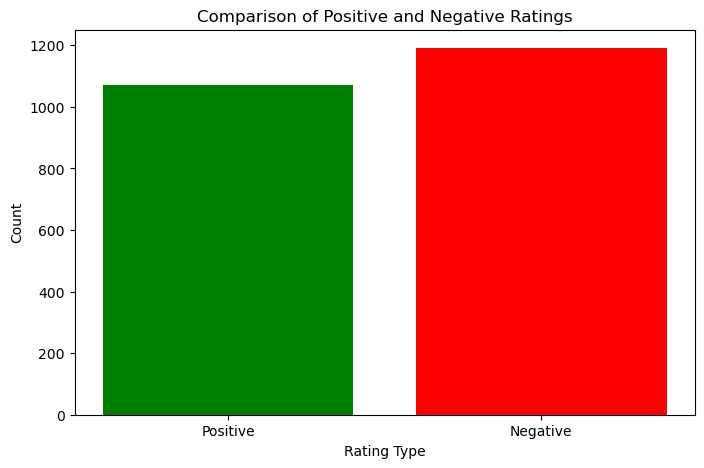

In [59]:
# Data to plot
ratings = ['Positive', 'Negative']
counts = [pos_count, neg_count]

# Creating the bar chart
plt.figure(figsize=(8, 5))  # You can adjust the size as needed
plt.bar(ratings, counts, color=['green', 'red'])  # Green for positive, red for negative
plt.xlabel('Rating Type')
plt.ylabel('Count')
plt.title('Comparison of Positive and Negative Ratings')
plt.show()

#### Putting each of the following into one big function:
- Making text lowercase
- Removing stopwords
- Cleaning and removing punctuations
- Cleaning and removing repeating characters
- Cleaning and removing numeric numbers
- Getting tokenization of the text
- Applying Stemming
- Applying Lemmatizer
- Stripping unnecessary characters

In [60]:
def preprocess_text(df):
    # Convert text to lowercase
    df['text'] = df['text'].str.lower()

    # Remove punctuation
    punctuations_list = string.punctuation
    translator = str.maketrans('', '', punctuations_list)
    df['text'] = df['text'].apply(lambda text: text.translate(translator))

    # Remove repeating characters
    df['text'] = df['text'].apply(lambda text: re.sub(r'(.)\1+', r'\1', text))

    # Remove numbers
    df['text'] = df['text'].apply(lambda text: re.sub('[0-9]+', '', text))

    # Tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    df['text'] = df['text'].apply(lambda text: tokenizer.tokenize(text))

    # Lemmatization
    lm = WordNetLemmatizer()
    df['text'] = df['text'].apply(lambda words: [lm.lemmatize(word) for word in words])

    # Convert list of words back to string
    df['text'] = df['text'].apply(lambda words: ' '.join(words))

    # Remove stopwords (moved to the end)
    STOPWORDS = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda text: " ".join([word for word in text.split() if word not in STOPWORDS]))

    # Return the modified DataFrame
    return df

In [61]:
df.head()

,title,text,rating
0,"""Significant delays""",✅ Trip Verified | Significant delays with fir...,0
1,"""food quality was abysmal""",Not Verified | I recently flew with Qantas a...,0
2,"""wasted money on a business ticket""",✅ Trip Verified | My husband and I went to Au...,0
3,"""think about the food needs""",✅ Trip Verified | I travelled with my husband...,0
4,"""Another horrific flight""",✅ Trip Verified | Another horrific flight end...,0


In [62]:
df = preprocess_text(df)

In [63]:
df.head()

,title,text,rating
0,"""Significant delays""",trip verified significant delay first anouncem...,0
1,"""food quality was abysmal""",verified recently flew qantas wa thoroughly di...,0
2,"""wasted money on a business ticket""",trip verified husband went auckland air new ze...,0
3,"""think about the food needs""",trip verified traveled husband daughter june s...,0
4,"""Another horrific flight""",trip verified another horific flight endured q...,0


In [64]:
df['title'] = df['title'].str.strip('"')

In [66]:
df['text'] = df['title'] + ' ' + df['text']

In [68]:
df.drop('title', axis=1, inplace=True)   

In [69]:
df.head()

,text,rating
0,Significant delays trip verified significant d...,0
1,food quality was abysmal verified recently fle...,0
2,wasted money on a business ticket trip verifie...,0
3,think about the food needs trip verified trave...,0
4,Another horrific flight trip verified another ...,0


### Training a ML model

#### Preparing the input features for training

In [57]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [58]:
X = tfidf.fit_transform(df['text']).toarray()

In [59]:
X.shape

(2263, 3000)

In [61]:
y = df['rating'].values

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

#### Model Training

In [69]:
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [70]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [72]:
train_classifier(xgb,X_train,y_train,X_test,y_test)

(0.8079470198675497, 0.808641975308642)

In [73]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(xgb,open('model.pkl','wb'))